<a href="https://colab.research.google.com/github/THEfreshman2004/miniproject1_diffusion/blob/main/diffusion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from data import load_dataset_and_make_dataloaders
dl , info = load_dataset_and_make_dataloaders(
    dataset_name='FashionMNIST',
    root_dir='data', # choose the directory to store the data
    batch_size=64,
    num_workers=0   # you can use more workers if you see the GPU is waiting for the batches
)
train_load = dl.train
valid_load = dl.valid
Sigma = info.sigma_data #the global standard deviation of the data

100%|██████████| 26.4M/26.4M [00:02<00:00, 10.4MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 173kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.35MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 19.2MB/s]


In [ ]:
device = 'cuda' #Choose the device

In [91]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from PIL import Image
from torchvision.utils import make_grid
from matplotlib import pyplot as plt
import numpy as np

class Model(nn.Module):
    def __init__(
        self,
        image_channels: int = 1,
        nb_channels: int = 96, #divisible by 8 (for the group normalization)
        num_blocks: int = 6,
        cond_channels: int = 128, #Better to be even,
        nbr_classes : int = 10,
        null_init = False #It declares if we want to choose null initialisation or not
    ) -> None:
        super().__init__()
        self.noise_emb = NoiseEmbedding(cond_channels)
        self.conv_in = nn.Conv2d(image_channels, nb_channels, kernel_size=3, padding=1)
        self.batch = conditional_BN(num_channels=nb_channels,cond_channels=cond_channels)
        self.blocks = nn.ModuleList([ResidualBlock(nb_channels,cond_channels=cond_channels) for _ in range(num_blocks)])
        self.conv_out = nn.Conv2d(nb_channels, image_channels, kernel_size=3, padding=1)
        self.activation = nn.SiLU()

        #class conditioning:
        self.class_embed = nn.Embedding(nbr_classes,cond_channels)
        self.cond_proj = nn.Sequential(nn.Linear(2*cond_channels,4*cond_channels),
                                       nn.SiLU(),
                                       nn.Linear(4*cond_channels,cond_channels))

        if null_init:
            #Null initialisation for conv_out:
            nn.init.zeros_(self.conv_out.weight)
            if self.conv_in.bias is not None:
                nn.init.zeros_(self.conv_out.bias)

            #Null initialisation for resBlocks:
            for block in self.blocks:
                for m in block.modules():
                    if isinstance(m,nn.Conv2d):
                        nn.init.zeros_(m.weight)
                        if m.bias is not None:
                            nn.init.zeros_(m.bias)

    def forward(self, noisy_input: torch.Tensor, c_noise: torch.Tensor,clas : int) -> torch.Tensor: #clas are the labels of our batch
        device = noisy_input.device
        cond_noise = self.noise_emb(c_noise.to(device)) # It has shape (B,cond_channels)
        cond_class = self.class_embed(clas.to(device)) #class embedding shape (B,cond_channels)
        cond = torch.cat([cond_noise, cond_class], dim=-1)
        cond = self.cond_proj(cond) #instead of simple addition we do the following to combine class cond with noise cond
        x = self.conv_in(noisy_input)
        x = self.activation(x) #conv -> norm -> activ
        for block in self.blocks:
            x = block(x,cond)
        x = self.conv_out(x)
        return x


class NoiseEmbedding(nn.Module):
    def __init__(self, cond_channels: int) -> None:
        super().__init__()
        assert cond_channels % 2 == 0
        self.register_buffer('weight', torch.randn(1, cond_channels // 2))

    def forward(self, input: torch.Tensor) -> torch.Tensor: #input needs to heave shape (B,)
        assert input.ndim == 1
        f = 2 * torch.pi * input.unsqueeze(1) @ self.weight
        return torch.cat([f.cos(), f.sin()], dim=-1) #it produces noise_emb with shape (B,cond_channels)

#This is just the residual block
class ResidualBlock(nn.Module):
    def __init__(self, nb_channels: int,cond_channels) -> None:
        super().__init__()
        self.norm1 = conditional_BN(nb_channels,cond_channels)
        self.conv1 = nn.Conv2d(nb_channels, nb_channels, kernel_size=3, stride=1, padding=1)
        self.norm2 = conditional_BN(nb_channels,cond_channels)
        self.conv2 = nn.Conv2d(nb_channels, nb_channels, kernel_size=3, stride=1, padding=1)
        self.activation = nn.SiLU()

    def forward(self, x: torch.Tensor,cond) -> torch.Tensor:
        y = self.activation(self.norm1(self.conv1(x),cond)) #conv -> norm -> activ
        y = self.activation(self.norm2(self.conv2(y),cond))
        return x+y

class conditional_BN(nn.Module): #The idea is to have regular batchNorm with no coefficients (affine = False)
    #And then we modify the output using our own predicted affine parameters
    def __init__(self,num_channels,cond_channels):
        super().__init__()
        self.num_channels = num_channels
        self.bn = nn.GroupNorm(num_groups=8,num_channels=num_channels,affine=False)
        self.lin = nn.Sequential(
            nn.Linear(cond_channels, 2 * num_channels),
            nn.SiLU(),
            nn.Linear(2 * num_channels, 2 * num_channels)
        ) #MLP that predicts the affine parameters
        #We need a gamma and a beta for each channel, that's why we have 2*num_channels
    def forward(self,x,cond): #cond:noise conditioning
        x = self.bn(x)
        out = self.lin(cond)
        gamma,beta = out.chunk(2,dim=-1) #We split the output since we have 2*num_channels
        gamma = gamma.view(-1,self.num_channels,1,1) #We do this to make the coefficients broadcastable when manipluating them with x
        beta = beta.view(-1,self.num_channels,1,1) #this has the same effect as doing unsqueeze multiple times
        return gamma * x + beta


def normalize_data(x):
    return (x - 0.5) * 2  # [0,1] -> [-1,1]

def train_model(model,optimizer,criterion,nb_epochs): #trained to give the class cl
    model.train(True) #We're in training mode
    loss_list = []
    print(f'Our training is {nb_epochs} epochs.')
    for i in range(nb_epochs):
      n_batches = 0
      epoch_loss = 0
      for images,labels in train_load:
          images = normalize_data(images)
          images = images.to(device)
          labels = labels.to(device=device,dtype=torch.long)
          B = images.size(0) #the batch size
          sigma = sample_sigma(B).to(device) #sigma has shape (B,)
          noise = torch.randn_like(images,device=device)*sigma.view(-1,1,1,1)
          noisy_batch = images + noise
          c_in,c_out,c_skip,cnoise = sample_constants(Sigma,sigma)
          output = model(c_in*noisy_batch,cnoise,labels)
          loss = criterion(output,(images-c_skip*noisy_batch)/c_out)
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()
          epoch_loss += loss.item()
          n_batches += 1
      if i+1 % 10 == 0: #get the checkpoint after every 10 epochs
        checkpoint = {
            "epoch": nb_epochs,
            "model_state": model.state_dict(),
            "optimizer_state": optimizer.state_dict(),
            "loss": loss_list
        }
        torch.save(checkpoint, "checkpoint_.pth")
      print(f'the loss at epoch {i} is : ',epoch_loss/n_batches)
      loss_list.append(epoch_loss/n_batches)
    model.train(False)
    return loss_list



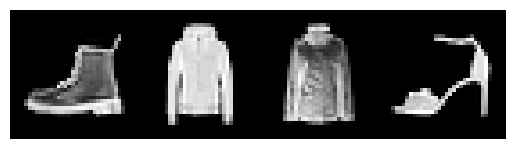

In [92]:
def sample_sigma(n, loc=-1.0, scale=0.8, sigma_min=2e-3, sigma_max=80): #it samples sigma for size n=Batch_size -> (B,) shape
    return (torch.randn(n) * scale + loc).exp().clip(sigma_min, sigma_max)

def sample_constants(sigma_data,sigma): #It return c_in,c_out,c_skip and c_noise
    c_in = 1/(torch.sqrt((sigma_data**2 + sigma**2)))
    c_out = (sigma*sigma_data)/torch.sqrt(sigma**2+sigma_data**2)
    c_skip = sigma_data**2/(sigma**2 + sigma_data**2)
    c_noise = 0.25*torch.log(sigma)

    c_in = c_in.view(-1,1,1,1)
    c_out = c_out.view(-1,1,1,1)
    c_skip = c_skip.view(-1,1,1,1)
    c_noise = c_noise.view(-1) #because we use it in the noise_emb layer, it needs to have shape (B,)

    return c_in,c_out,c_skip,c_noise


def build_sigma_schedule(steps, rho=7, sigma_min=2e-3, sigma_max=80):
    min_inv_rho = sigma_min ** (1 / rho)
    max_inv_rho = sigma_max ** (1 / rho)
    sigmas = (max_inv_rho + torch.linspace(0, 1, steps) * (min_inv_rho - max_inv_rho)) ** rho
    return sigmas


def euler_sampling(model, batch_size, steps, sigma_data, class_labels=None):
    """
    Generate samples with Euler method

    Args:
        model: Trained model
        batch_size: Number of samples to generate
        steps: Number of diffusion steps
        sigma_data: Data standard deviation
        class_labels: Tensor of class labels (length batch_size). If None, generate random classes
    """
    model.eval()
    sigmas = build_sigma_schedule(steps)

    # Create class labels if not provided
    if class_labels is None:
        class_labels = torch.randint(0, 10, (batch_size,), device=device)
    else:
        # Ensure class_labels is the correct shape
        if class_labels.numel() == 1:
            class_labels = torch.full((batch_size,), class_labels.item(), device=device)
        class_labels = class_labels.to(device)

    # Start from pure noise
    x = torch.randn(batch_size, 1, 32,32).to(device) * sigmas[0]

    with torch.no_grad():
      for i in range(len(sigmas) - 1):
          sigma = sigmas[i]
          sigma_next = sigmas[i + 1]

          sigma_tensor = torch.full((batch_size,), sigma, device=device)
          c_in, c_out, c_skip, c_noise = sample_constants(sigma_data, sigma_tensor)

          denoised = model(c_in * x, c_noise, class_labels)
          x_denoised = c_skip * x + c_out * denoised
          x_denoised = torch.clamp(x_denoised, -1.5, 1.5)

          d = (x - x_denoised) / sigma
          x = x + d * (sigma_next - sigma)

          noise = torch.randn_like(x)
          x = x + noise * torch.sqrt(sigma**2 - sigma_next**2)

      # FINAL CLEAN DENOISE
      sigma = sigmas[-1]
      sigma_tensor = torch.full((batch_size,), sigma, device=device)
      c_in, c_out, c_skip, c_noise = sample_constants(sigma_data, sigma_tensor)
      denoised = model(c_in * x, c_noise, class_labels)
      x = c_skip * x + c_out * denoised


    # Denormalize to [0, 1]
    return torch.clamp((x + 1) / 2, 0, 1).cpu(), class_labels.cpu()

def huen_sampling(model, batch_size, steps, sigma_data, class_labels=None):
    """
    Generate samples with Huen's method (2nd order predictor-corrector)

    Args:
        model: Trained model
        batch_size: Number of samples to generate
        steps: Number of diffusion steps
        sigma_data: Data standard deviation
        class_labels: Tensor of class labels (length batch_size). If None, generate random classes

    Returns:
        samples, class_labels
    """
    model.eval()
    sigmas = build_sigma_schedule(steps)

    # Create class labels if not provided
    if class_labels is None:
        class_labels = torch.randint(0, 10, (batch_size,), device=device)
    else:
        # Ensure class_labels is the correct shape
        if class_labels.numel() == 1:
            class_labels = torch.full((batch_size,), class_labels.item(), device=device)
        class_labels = class_labels.to(device)

    # Start from pure noise
    x = torch.randn(batch_size, 1, 28, 28).to(device) * sigmas[0]
    process = []  # Store intermediate steps for visualization

    with torch.no_grad():
        for i, sigma in enumerate(sigmas):
            # If last step, just denoise
            if i == len(sigmas) - 1:
                sigma_tensor = torch.full((batch_size,), sigma, device=device)
                c_in, c_out, c_skip, c_noise = sample_constants(sigma_data, sigma_tensor)

                denoised = model(c_in * x, c_noise, class_labels)
                x = c_skip * x + c_out * denoised
                break

            # Current sigma and next sigma
            sigma_curr = sigma
            sigma_next = sigmas[i + 1]

            # --- Euler predictor step (1st order) ---
            sigma_curr_tensor = torch.full((batch_size,), sigma_curr, device=device)
            c_in_curr, c_out_curr, c_skip_curr, c_noise_curr = sample_constants(sigma_data, sigma_curr_tensor)

            # Denoise at current sigma
            denoised_curr = model(c_in_curr * x, c_noise_curr, class_labels)
            x_denoised_curr = c_skip_curr * x + c_out_curr * denoised_curr

            # Compute drift at current point
            drift_curr = (x - x_denoised_curr) / sigma_curr

            # Euler predictor
            x_pred = x + drift_curr * (sigma_next - sigma_curr)

            # --- Huen corrector step (2nd order) ---
            sigma_next_tensor = torch.full((batch_size,), sigma_next, device=device)
            c_in_next, c_out_next, c_skip_next, c_noise_next = sample_constants(sigma_data, sigma_next_tensor)

            # Denoise at predicted point
            denoised_next = model(c_in_next * x_pred, c_noise_next, class_labels)
            x_denoised_next = c_skip_next * x_pred + c_out_next * denoised_next

            # Compute drift at predicted point
            drift_next = (x_pred - x_denoised_next) / sigma_next

            # Huen update (average of drifts)
            x = x + 0.5 * (drift_curr + drift_next) * (sigma_next - sigma_curr)

            # Store process for visualization
            if i % (steps // 10) == 0:  # Store every 10%
                process.append(x.clone().cpu())

    # Denormalize to [0, 1]
    samples = torch.clamp((x + 1) / 2, 0, 1).cpu()

    return samples, class_labels.cpu(), process

#We visualize the images using the process output from the Euler_sampling function
import time
def visualize_images(images):
        x = images.clamp(-1, 1).add(1).div(2).mul(255).byte()  # [-1., 1.] -> [0., 1.] -> [0, 255]
        x = make_grid(x)
        x = Image.fromarray(x.permute(1, 2, 0).cpu().numpy())
        plt.imshow(x)
        plt.axis("off")
        plt.show()

images,_ = next(iter(train_load))
visualize_images(images[:4])


Our training is 400 epochs.
the loss at epoch 0 is :  0.49282229110560455
the loss at epoch 1 is :  0.24056923568553631
the loss at epoch 2 is :  0.227871088268202
the loss at epoch 3 is :  0.2217484893434493
the loss at epoch 4 is :  0.2171748021755682
the loss at epoch 5 is :  0.21428447355852104
the loss at epoch 6 is :  0.21069957973325953
the loss at epoch 7 is :  0.20827951634783878
the loss at epoch 8 is :  0.20602860905782647
the loss at epoch 9 is :  0.20501071717733008
the loss at epoch 10 is :  0.20347142139511645
the loss at epoch 11 is :  0.20185909946175182
the loss at epoch 12 is :  0.20104046051611985
the loss at epoch 13 is :  0.19909365812454688
the loss at epoch 14 is :  0.198917294535643
the loss at epoch 15 is :  0.19790978527739836
the loss at epoch 16 is :  0.19635886773276512
the loss at epoch 17 is :  0.19652618143869482
the loss at epoch 18 is :  0.19569529707322036
the loss at epoch 19 is :  0.19487726501644115
the loss at epoch 20 is :  0.19444307804946095
t

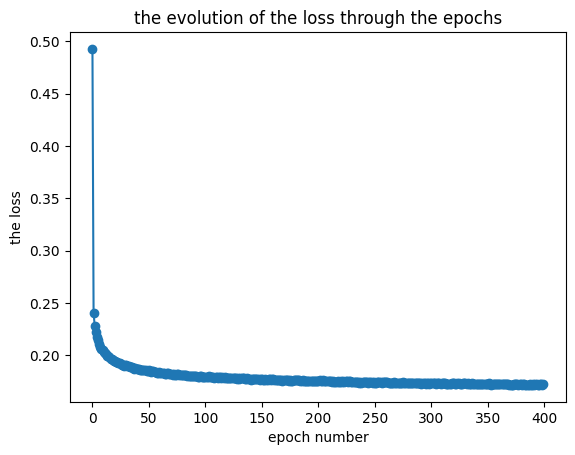

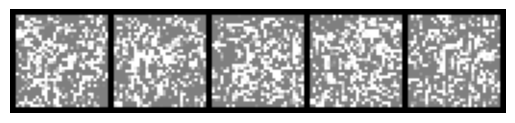

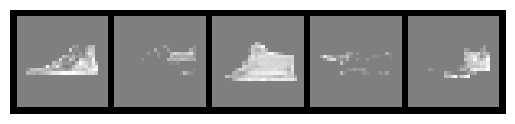

In [30]:
#Let's test:
nb_epochs = 400
clas = torch.tensor([7],dtype=torch.long,device = 'cuda')
model = Model().to('cuda')
opt = torch.optim.AdamW(model.parameters(),lr=0.0001,weight_decay = 1e-6)
criter = nn.MSELoss()
loss_list = train_model(model,opt,criter,nb_epochs)

#Let's plot the loss against the epochs
plt.plot(np.arange(nb_epochs),loss_list,marker='o')
plt.xlabel('epoch number')
plt.ylabel('the loss')
plt.title('the evolution of the loss through the epochs')
plt.show()

#visualize the results:

images,_ = euler_sampling(model,5,500,Sigma,clas)
images1,_,_ = huen_sampling(model,5,500,Sigma,clas)
visualize_images(images)
visualize_images(images1)



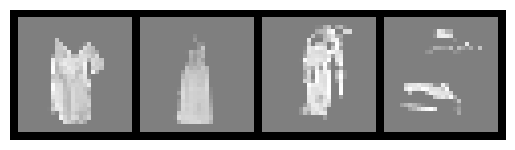

std: 0.25111421942710876 mean: 0.11121262609958649


In [98]:
m = Model()
ch = torch.load('checkpoint_.pth',map_location=device)
m = m.to(device)
clas = torch.tensor([3],dtype=torch.long,device = 'cuda')


m.load_state_dict(ch['model_state'])
opt.load_state_dict(ch['optimizer_state'])


images, _,_ = huen_sampling(model, 4, 500, Sigma, clas)

visualize_images(images)


print("std:", images.std().item(), "mean:", images.mean().item())